In [44]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing # экспоненциальное сглаживание
from statsmodels.tsa.stattools import adfuller # проверка на стационарность ряда
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm # Для определения гиперпараметров модели

In [46]:
df22 = pd.read_csv('data/2022.csv')
df23 = pd.read_csv('data/2023.csv')
df24 = pd.read_csv('data/2024.csv')
df25 = pd.read_csv('data/2025.csv')

In [47]:
# Соединим таблицы 
df = pd.concat([df22,df23,df24,df25], ignore_index=True,axis=0)

# Сменим название
df.columns = ['Дата','1.P вых1','2.P вых2','3.Р вых','4.T вых','5.Т вх',"6.P вх",'7.Q мгн1','8.Q мгн2', '9.Q мгн сн', '10.Q сут1', '11.Q сут2', '712.Q сут сн', '13. Т воздуха']
# Выходные расходы по 2 ниткам суммируем в 1
df['Q мгн']= df['7.Q мгн1'] + df['8.Q мгн2']
df['Q сут'] = df['10.Q сут1'] + df['11.Q сут2']
# Удаляем лишние столбцы
df = df.drop(columns=['1.P вых1','2.P вых2','7.Q мгн1','8.Q мгн2','10.Q сут1','11.Q сут2'],axis=1)
# Снова переименуем
df.columns = ['Дата','Р вых','T вых','Т вх','P вх','Q мгн сн',"Q сут сн",'Т_воздуха','Q_мгн', 'Q сут']
# Дату приведем к формату
df['Дата'] = pd.to_datetime(df['Дата'])
# Подгрузим теплоемкость
df['год'] = df['Дата'].dt.year
df['месяц'] = df['Дата'].dt.month
heat_capacity_df = pd.read_excel('data/Q по Шакше.xlsx')
# Объединяем по году и месяцу
df = df.merge(heat_capacity_df, on=['год', 'месяц'], how='left')
df = df.drop(['год', 'месяц'], axis=1)

In [48]:
df = df[df['Дата']< '2025-10-01 00:00:00']

In [49]:
df.isna().sum()

Дата              0
Р вых           234
T вых           230
Т вх            230
P вх            235
Q мгн сн        345
Q сут сн        239
Т_воздуха       235
Q_мгн           301
Q сут           265
Теплоемкость      0
dtype: int64

In [50]:
df_base = df[['Дата','Q_мгн',"Т_воздуха", "Теплоемкость"]]
df_base = df_base.set_index('Дата')
df_base['Q_мгн'] = df_base['Q_мгн'].round(0)
df_base["Т_воздуха"] = df_base["Т_воздуха"].round(1)
df_base['Теплоемкость'] = df_base['Теплоемкость'].round(0)

In [51]:
df_base[:500].to_csv('data/bf_base.csv')

In [52]:
df_base.isna().sum()

Q_мгн           301
Т_воздуха       235
Теплоемкость      0
dtype: int64

# Подготовка данных

## Проверка пропущенных временных интервалов

In [53]:

# Проверка непрерывности
print("Информация о временном ряде:")
print(f"Начало: {df_base.index.min()}")
print(f"Конец: {df_base.index.max()}")
print(f"Всего записей: {len(df_base)}")

# Создаем полный временной диапазон
full_range = pd.date_range(start=df_base.index.min(), end=df_base.index.max(), freq='H')
print(f"Ожидаемое количество записей: {len(full_range)}")

# Находим пропущенные временные метки
missing_times = full_range.difference(df_base.index)
print(f"Пропущенных временных меток: {len(missing_times)}")

if len(missing_times) > 0:
    print("\nПримеры пропущенных временных меток:")
    print(missing_times[:10])

Информация о временном ряде:
Начало: 2022-01-01 00:00:00
Конец: 2025-09-30 23:00:00
Всего записей: 32856
Ожидаемое количество записей: 32856
Пропущенных временных меток: 0


## Интерполяция пропусков

In [54]:
# Проверяем пропуски в значениях
print("Пропуски по столбцам:")
print(df_base.isna().sum())

# Интерполяция пропусков
df_filled = df_base.copy()

# Для числовых столбцов используем интерполяцию
numeric_cols = ['Q_мгн', 'Т_воздуха']
for col in numeric_cols:
    # Линейная интерполяция для временного ряда
    df_filled[col] = df_filled[col].interpolate(method='linear')
    
    # Если остались пропуски в начале/конце, заполняем forward/backfill
    df_filled[col] = df_filled[col].fillna(method='ffill').fillna(method='bfill')

print("\nПосле интерполяции:")
print(df_filled.isna().sum())

Пропуски по столбцам:
Q_мгн           301
Т_воздуха       235
Теплоемкость      0
dtype: int64

После интерполяции:
Q_мгн           0
Т_воздуха       0
Теплоемкость    0
dtype: int64


## Обработка выбросов

### 1. Мгновенный расход

Выбросы удалим с помощью сглаживания с окном 5


In [55]:
# Функция для анализа разных окон сглаживания
def analyze_smoothing(df, column='Q_мгн', windows=[3, 5, 7, 12, 24]):
    fig, axes = plt.subplots(len(windows) + 1, 1, figsize=(15, 4 * (len(windows) + 1)))
    
    # Исходные данные
    axes[0].plot(df.index, df[column], 'b-', alpha=0.7, linewidth=1, label='Исходные')
    axes[0].set_title('Исходные данные')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Сглаженные данные для разных окон
    for i, window in enumerate(windows, 1):
        smoothed = df[column].rolling(window=window, center=True).mean()
        axes[i].plot(df.index, df[column], 'gray', alpha=0.3, linewidth=0.5, label='Исходные')
        axes[i].plot(df.index, smoothed, 'r-', linewidth=1.5, label=f'Сглаживание (окно={window})')
        axes[i].set_title(f'Сглаживание с окном {window}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Убрали проблемную строку с возвратом
    # Функция теперь только визуализирует, не возвращает данные

# Анализ сглаживания
analyze_smoothing(df_filled, 'Q_мгн')

# Выбираем оптимальное окно и применяем
optimal_window = 5  # Начнем с этого, потом можно изменить
df_filled['Q_мгн_smoothed'] = df_filled['Q_мгн'].rolling(window=optimal_window, center=True).mean()

# Заполняем пропуски после rolling
df_filled['Q_мгн_smoothed'] = df_filled['Q_мгн_smoothed'].fillna(df_filled['Q_мгн'])

KeyboardInterrupt: 

### 2. Температура воздуха

Выбросы удалим с помощью метода Тьюки

In [ ]:
# Обработка выбросов в температуре интерполяцией
def handle_temperature_outliers(df, column='Т_воздуха'):
    # Определяем границы выбросов
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Создаем копию столбца
    cleaned = df[column].copy()
    
    # Помечаем выбросы как NaN
    outlier_mask = (cleaned < lower_bound) | (cleaned > upper_bound)
    cleaned[outlier_mask] = np.nan
    
    print(f"Обнаружено выбросов в температуре: {outlier_mask.sum()}")
    
    # Интерполируем пропуски (выбросы)
    cleaned = cleaned.interpolate(method='time')  # метод 'time' учитывает временные интервалы
    
    # Если остались пропуски в начале/конце, заполняем соседними значениями
    cleaned = cleaned.fillna(method='bfill').fillna(method='ffill')
    
    return cleaned, outlier_mask

# Применяем обработку
df_filled['Т_воздуха_cleaned'], temp_outlier_mask = handle_temperature_outliers(df_filled)

Обнаружено выбросов в температуре: 47


In [ ]:
df_filled = df_filled[['Q_мгн_smoothed','Т_воздуха_cleaned','Теплоемкость']]

In [ ]:
df_filled.columns = ['Q_мгн','Т_воздуха','Теплоемкость']

## Получили таблицу для работы без выбросов и пропусков

In [ ]:
df_filled.head(1)

,Q_мгн,Т_воздуха,Теплоемкость
Дата,,,
2022-01-01,29453.0,-7.5,8109.0


In [ ]:
df_filled[800:].to_csv('data/df_filled.csv')

## Разложим график на составляющие

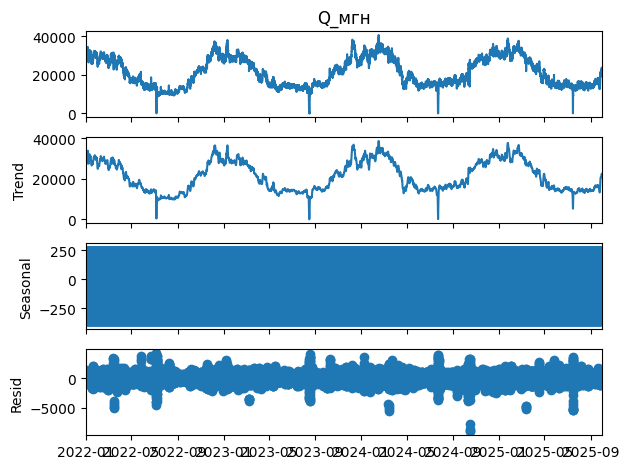

In [ ]:
result = seasonal_decompose(df_filled['Q_мгн'].dropna())
fig = result.plot()
plt.show();

## Проверка на стационарность

In [ ]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(df_filled['Q_мгн'])

adf:  -3.104999246945557
p-value:  0.026185427141980362
Critical values:  {'1%': -3.4305493601932597, '5%': -2.861628112093246, '10%': -2.5668168993302585}
единичных корней нет, ряд стационарен


## Экспоненциальное сглаживание

In [ ]:
test_df = df_filled['Q_мгн'][:-1]

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(test_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast_test_df= model.forecast(1)

print(forecast_test_df)

2025-09-30 23:00:00    22293.800966
Freq: H, dtype: float64


# Корреляции

In [ ]:
# Создадим функцию для отображения ACF и PACF
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=3600)
    plot_pacf(series, ax=axes[1], lags=10, method="ywm")
    plt.show()

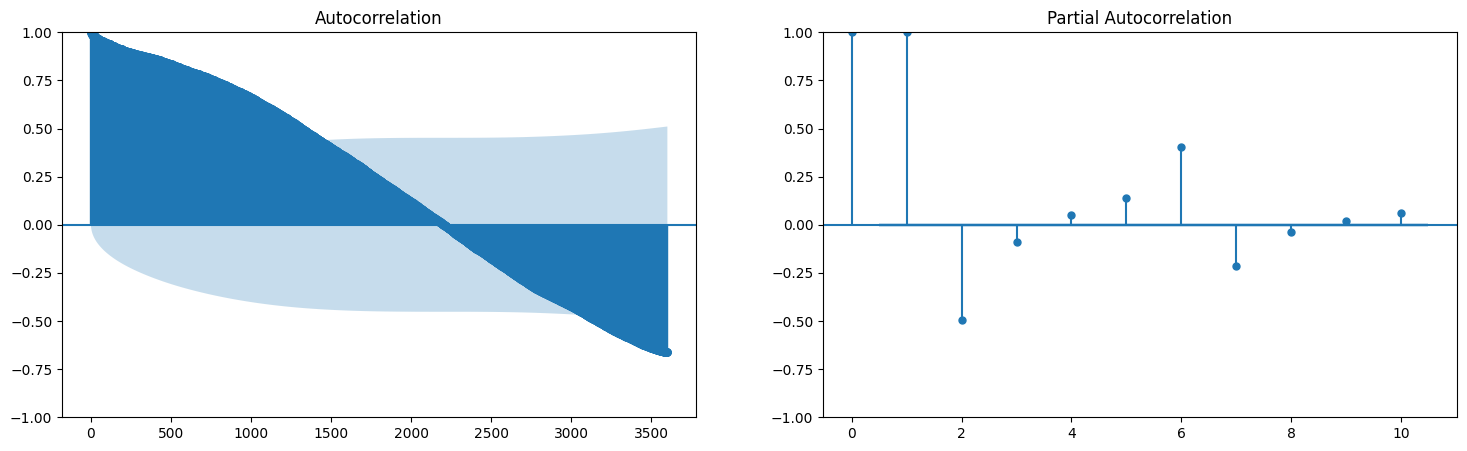

In [ ]:
plot_acf_pacf(df_filled['Q_мгн'])

# Создадим выборки

In [ ]:
train_data = df_filled[:len(df)-720]
test_data = df_filled[len(df)-720:]

# Модель AR

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
ar_model = AutoReg(train_data['Q_мгн'], lags=1).fit()
print(ar_model.summary());

                            AutoReg Model Results                             
Dep. Variable:                  Q_мгн   No. Observations:                32136
Model:                     AutoReg(1)   Log Likelihood             -226972.417
Method:               Conditional MLE   S.D. of innovations            282.634
Date:                Wed, 08 Oct 2025   AIC                         453950.833
Time:                        19:22:12   BIC                         453975.967
Sample:                    01-01-2022   HQIC                        453958.871
                         - 08-31-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8580      4.781      3.107      0.002       5.487      24.229
Q_мгн.L1       0.9993      0.000   4733.704      0.000       0.999       1.000
                                    Roots           

In [ ]:
ar_pred = ar_model.predict(start=len(train_data['Q_мгн']), end=(len(df_filled['Q_мгн'])-1), dynamic=False)

In [ ]:
ar_pred

2025-09-01 00:00:00    13669.849039
2025-09-01 01:00:00    13674.894454
2025-09-01 02:00:00    13679.936246
2025-09-01 03:00:00    13684.974420
2025-09-01 04:00:00    13690.008977
                           ...     
2025-09-30 19:00:00    16492.316593
2025-09-30 20:00:00    16495.335973
2025-09-30 21:00:00    16498.353185
2025-09-30 22:00:00    16501.368231
2025-09-30 23:00:00    16504.381113
Freq: H, Length: 720, dtype: float64

In [ ]:
# Посчитаем метрику
from sklearn.metrics import mean_squared_error

mean_squared_error(test_data['Q_мгн'], ar_pred)

5311988.483136811

                               SARIMAX Results                                
Dep. Variable:                  Q_мгн   No. Observations:                26284
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -181889.724
Date:                Wed, 08 Oct 2025   AIC                         363789.449
Time:                        19:22:14   BIC                         363830.332
Sample:                    01-01-2022   HQIC                        363802.650
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.136e+04   1358.760     15.717      0.000    1.87e+04     2.4e+04
ar.L1          1.5876      0.006    278.888      0.000       1.576       1.599
ar.L2         -0.5886      0.006   -103.444      0.0

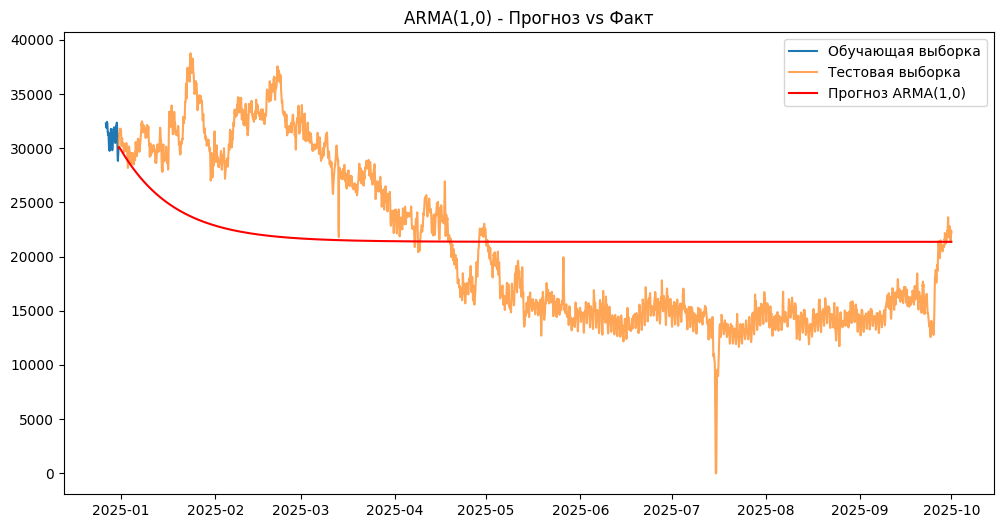

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Разделим данные на обучающую и тестовую выборки
train_size = int(len(df_filled) * 0.8)
train = df_filled['Q_мгн'][:train_size]
test = df_filled['Q_мгн'][train_size:]

# Модель ARMA(1,0) - то есть AR(1)
model = ARIMA(train, order=(2, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

# Прогноз на тестовой выборке
forecast = model_fit.forecast(steps=len(test))

# Оценка качества
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"\nКачество модели на тестовой выборке:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
plt.plot(test.index, test.values, label='Тестовая выборка', alpha=0.7)
plt.plot(test.index, forecast, label='Прогноз ARMA(1,0)', color='red')
plt.legend()
plt.title('ARMA(1,0) - Прогноз vs Факт')
plt.show()

In [ ]:
# Для обучающей и тестовой выборок
exog_train = df_filled['Т_воздуха'][:train_size]
exog_test = df_filled['Т_воздуха'][train_size:]

model_armax = ARIMA(train, exog=exog_train, order=(1, 0, 0))
model_armax_fit = model_armax.fit()
forecast_armax = model_armax_fit.forecast(steps=len(test), exog=exog_test)


Качество модели на тестовой выборке:
MSE: 60744841.62
MAE: 6868.95


Text(0.5, 1.0, 'ARMA(1,0) - Прогноз vs Факт')

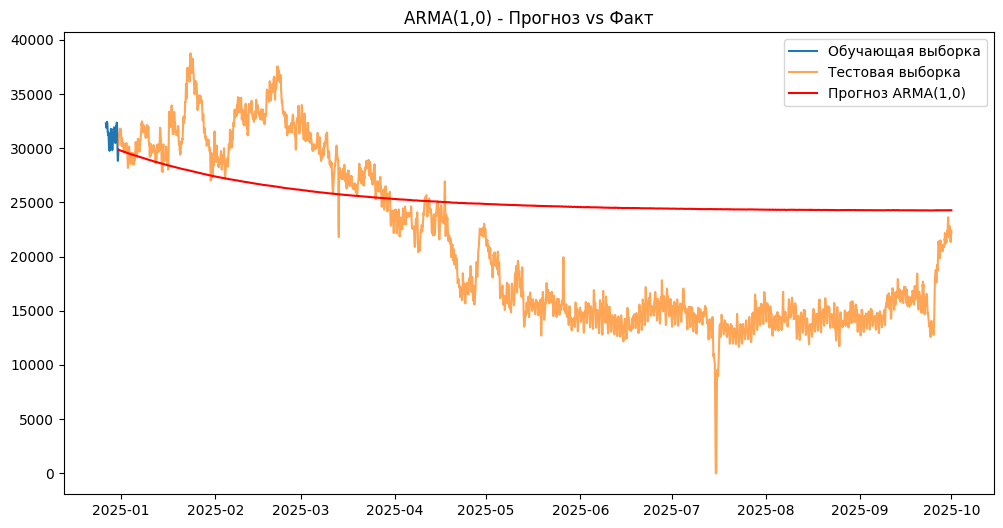

In [ ]:
# Оценка качества
mse = mean_squared_error(test, forecast_armax)
mae = mean_absolute_error(test, forecast_armax)
rmse = np.sqrt(forecast_armax)

print(f"\nКачество модели на тестовой выборке:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
#print(f"RMSE: {rmse:.2f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
plt.plot(test.index, test.values, label='Тестовая выборка', alpha=0.7)
plt.plot(test.index, forecast_armax, label='Прогноз ARMA(1,0)', color='red')
plt.legend()
plt.title('ARMA(1,0) - Прогноз vs Факт')

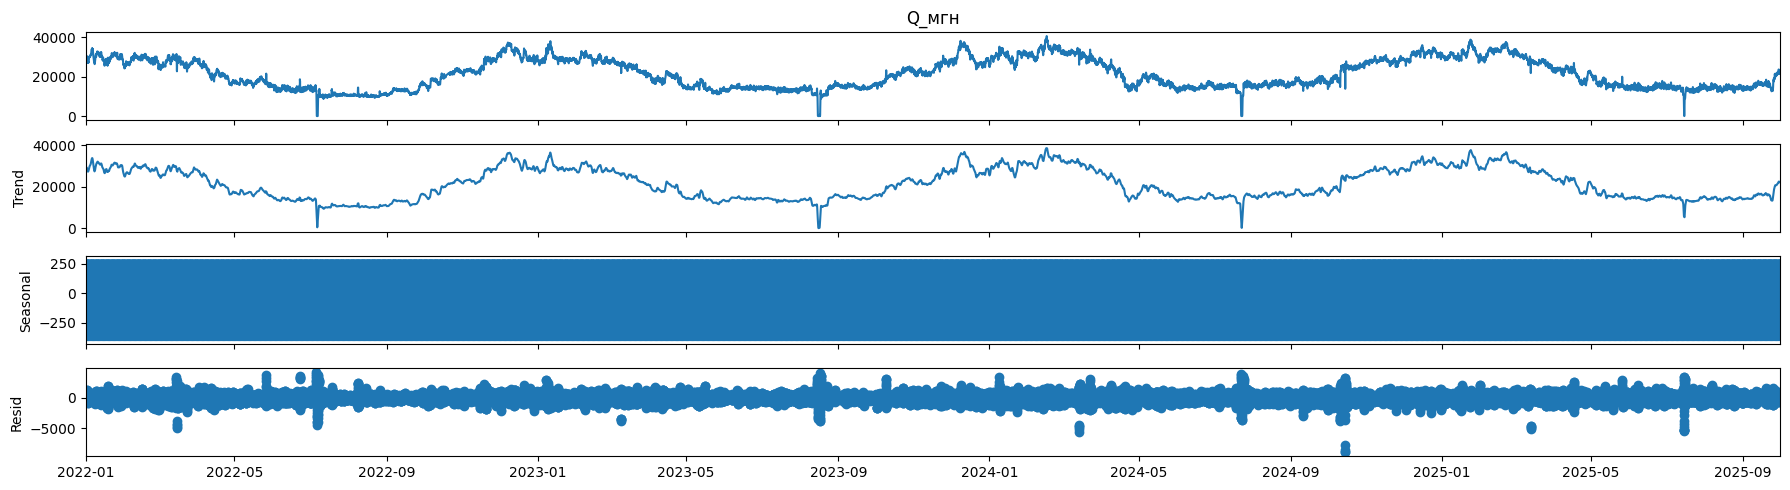

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Анализ сезонности
decomposition = seasonal_decompose(df_filled['Q_мгн'].dropna(), period=24)  # суточная сезонность
decomposition.plot()
plt.show()

# Разделение на train/test
train_size = int(len(df_filled) * 0.8)
train = df_filled['Q_мгн'][:train_size]
test = df_filled['Q_мгн'][train_size:]

In [ ]:
# Быстрый вариант с заведомо хорошими параметрами для часовых данных
try:
    # SARIMA с суточной сезонностью
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False)
    
    print(sarima_fit.summary())
    
    # Прогноз
    forecast = sarima_fit.forecast(steps=len(test))
    forecast_conf = sarima_fit.get_forecast(steps=len(test)).conf_int()
    
except Exception as e:
    print(f"Ошибка: {e}")
    # Попробуем более простую модель
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 0, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False)
    forecast = sarima_fit.forecast(steps=len(test))

                                     SARIMAX Results                                      
Dep. Variable:                              Q_мгн   No. Observations:                26284
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -181559.265
Date:                            Wed, 08 Oct 2025   AIC                         363128.530
Time:                                    19:24:51   BIC                         363169.404
Sample:                                01-01-2022   HQIC                        363141.729
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9958      0.001   1896.432      0.000       0.995       0.997
ma.L1          0.3288      0.002   

In [ ]:
# SARIMA с суточной сезонностью
model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 1, 1, 24),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
sarima_fit = model.fit(disp=False)
    
print(sarima_fit.summary())
    
# Прогноз
forecast = sarima_fit.forecast(steps=len(test))
forecast_conf = sarima_fit.get_forecast(steps=len(test)).conf_int()

MemoryError: Unable to allocate 501. MiB for an array with shape (26284, 50, 50) and data type float64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# Взять подвыборку для экономии памяти (первые 70%)
data = df_filled['Q_мгн']

# Разделение на train/test
train_size = int(len(data) * 0.9)
train = data[:train_size]
test = data[train_size:]

print(f"Размер обучающей выборки: {len(train)}")
print(f"Размер тестовой выборки: {len(test)}")

# Упрощенная SARIMA с меньшей сезонностью
try:
    # SARIMA(1,0,1)(1,0,1,6) - 6-часовая сезонность вместо 24
    model = SARIMAX(train,
                  order=(1, 0, 1),
                  seasonal_order=(1, 0, 1, 6),  # 6-часовая сезонность
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarima_fit = model.fit(disp=False, low_memory=True)
    
    print("=" * 50)
    print("SARIMA(1,0,1)(1,0,1,6) - Результаты:")
    print("=" * 50)
    print(sarima_fit.summary())
    
    # Прогноз
    forecast = sarima_fit.forecast(steps=len(test))
    
    # Метрики
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mse)
    
    print(f"\nМетрики качества:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"AIC: {sarima_fit.aic:.2f}")
    
    # Визуализация
    plt.figure(figsize=(15, 8))
    plt.plot(train.index[-100:], train.values[-100:], label='Обучающая выборка')
    plt.plot(test.index, test.values, label='Тестовые данные')
    plt.plot(test.index, forecast, label='Прогноз SARIMA', color='red', linewidth=2)
    plt.title('SARIMA(1,0,1)(1,0,1,6) - Прогноз')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Ошибка: {e}")

NameError: name 'df_filled' is not defined

Работаем с подвыборкой: 32856 записей
Размер обучающей выборки: 26284
Размер тестовой выборки: 6572
Экзогенные переменные: ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
SARIMAX(1,0,1)(1,0,1,24) - Результаты:
                                     SARIMAX Results                                      
Dep. Variable:                              Q_мгн   No. Observations:                26284
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -187262.934
Date:                            Wed, 08 Oct 2025   AIC                         374547.869
Time:                                    19:37:55   BIC                         374637.802
Sample:                                01-01-2022   HQIC                        374576.909
                                     - 12-31-2024                                         
Covariance Type:                           approx                                         
                   coef    std err

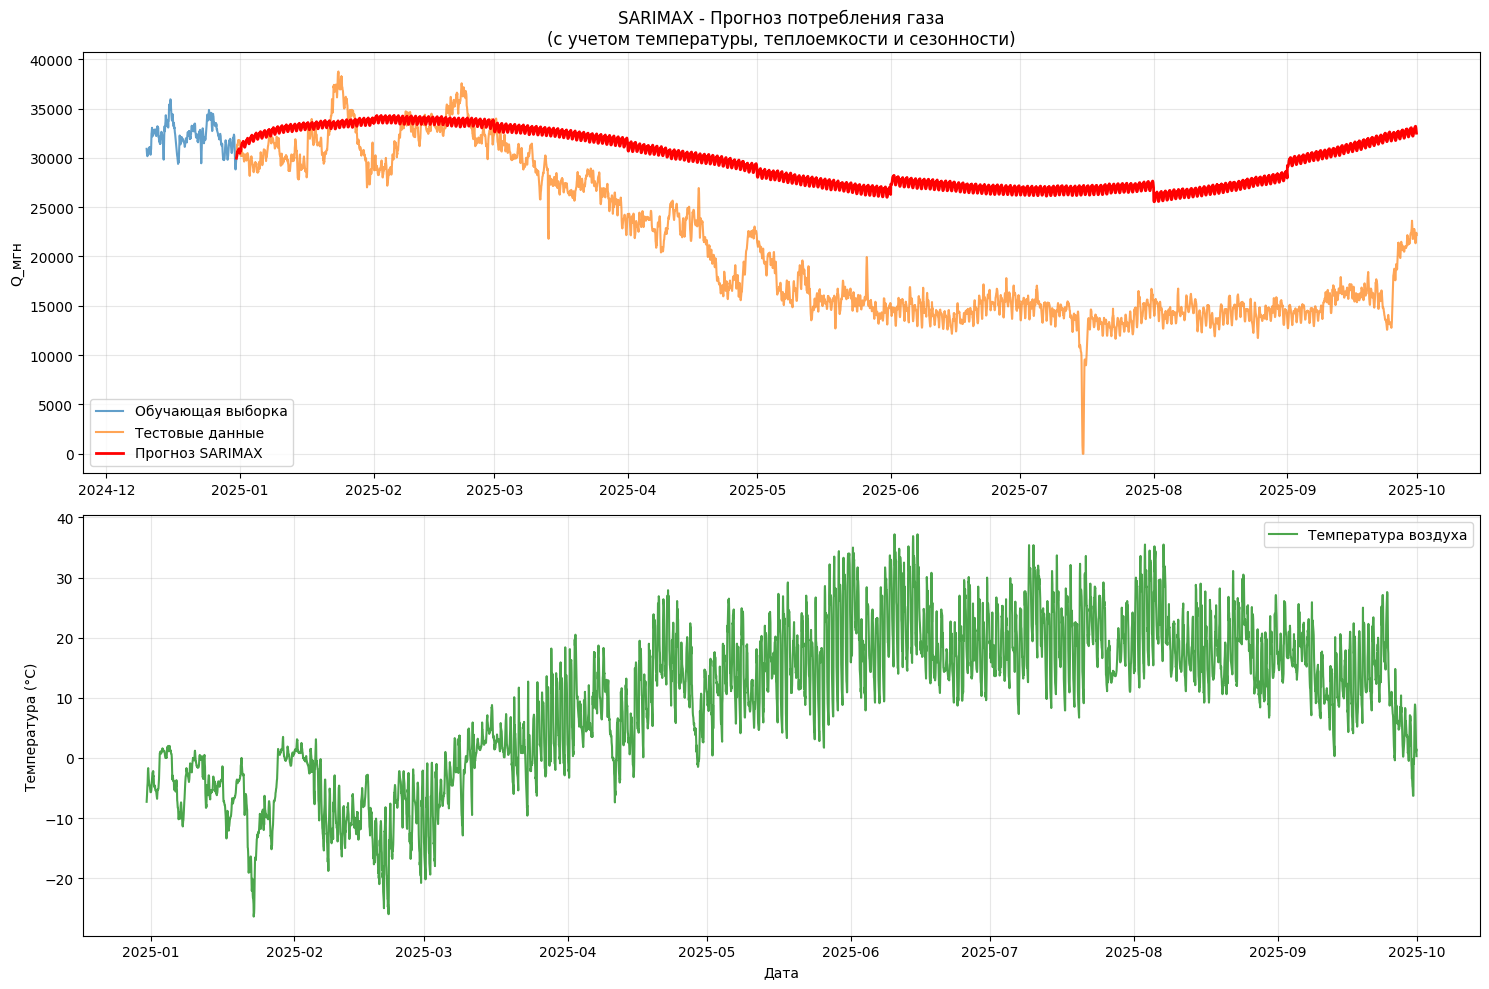

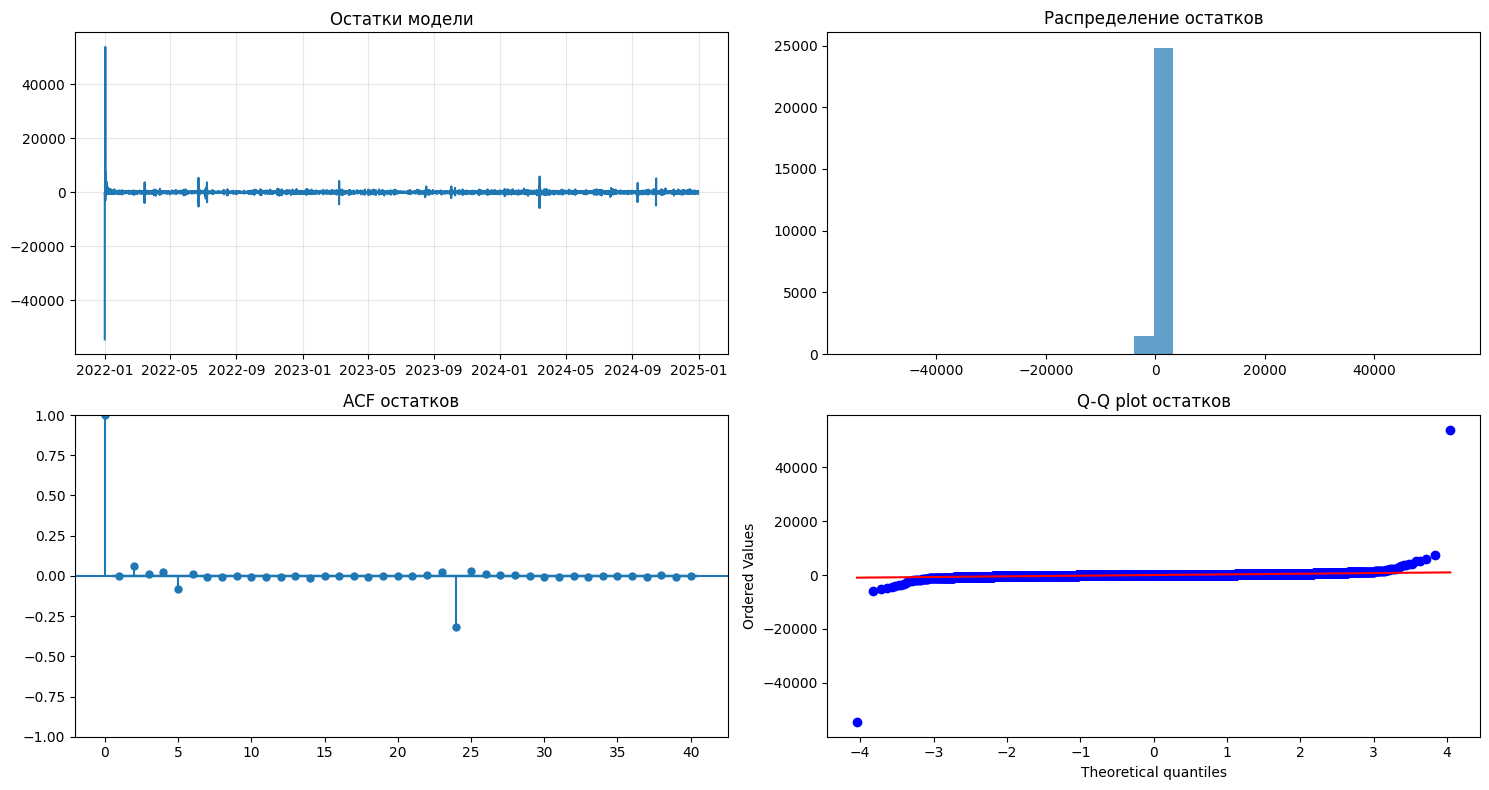

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


# Создаем дополнительные признаки для учета годовой сезонности
df_filled['month'] = df_filled.index.month
df_filled['day_of_year'] = df_filled.index.dayofyear
df_filled['hour'] = df_filled.index.hour

# Синус-косинус преобразования для годовой сезонности
df_filled['year_sin'] = np.sin(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['year_cos'] = np.cos(2 * np.pi * df_filled['day_of_year'] / 365)

# Синус-косинус для суточной сезонности
df_filled['day_sin'] = np.sin(2 * np.pi * df_filled['hour'] / 24)
df_filled['day_cos'] = np.cos(2 * np.pi * df_filled['hour'] / 24)

# Взять подвыборку для стабильности вычислений
#sample_size = min(5000, len(df_filled))
#df_sample = df_filled.iloc[sample_size:10000].copy()
df_sample = df_filled.copy()
print(f"Работаем с подвыборкой: {len(df_sample)} записей")

# Разделение на train/test
train_size = int(len(df_sample) * 0.8)
train = df_sample['Q_мгн'][:train_size]
test = df_sample['Q_мгн'][train_size:]

# Подготовка экзогенных переменных
exog_vars = ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
exog_train = df_sample[exog_vars][:train_size]
exog_test = df_sample[exog_vars][train_size:train_size+len(test)]

print(f"Размер обучающей выборки: {len(train)}")
print(f"Размер тестовой выборки: {len(test)}")
print(f"Экзогенные переменные: {exog_vars}")

# SARIMAX модель с суточной сезонностью
try:
    # SARIMAX(1,0,1)(1,0,1,24) с экзогенными переменными
    model = SARIMAX(train,
                  exog=exog_train,
                  order=(1, 0, 1),           # (p,d,q)
                  seasonal_order=(1, 0, 1, 24), # Суточная сезонность
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    sarimax_fit = model.fit(disp=False, low_memory=True, maxiter=50)
    
    print("=" * 60)
    print("SARIMAX(1,0,1)(1,0,1,24) - Результаты:")
    print("=" * 60)
    print(sarimax_fit.summary())
    
    # Прогноз
    forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)
    
    # Метрики качества
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mse)
    
    print(f"\nМетрики качества:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"AIC: {sarimax_fit.aic:.2f}")
    
    # Визуализация
    plt.figure(figsize=(15, 10))
    
    # Основной график
    plt.subplot(2, 1, 1)
    plt.plot(train.index[-500:], train.values[-500:], label='Обучающая выборка', alpha=0.7)
    plt.plot(test.index, test.values, label='Тестовые данные', alpha=0.7)
    plt.plot(test.index, forecast, label='Прогноз SARIMAX', color='red', linewidth=2)
    plt.title('SARIMAX - Прогноз потребления газа\n(с учетом температуры, теплоемкости и сезонности)')
    plt.ylabel('Q_мгн')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График температуры
    plt.subplot(2, 1, 2)
    plt.plot(test.index, df_sample['Т_воздуха'][train_size:train_size+len(test)], 
             label='Температура воздуха', color='green', alpha=0.7)
    plt.ylabel('Температура (°C)')
    plt.xlabel('Дата')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ остатков
    residuals = sarimax_fit.resid
    
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 2, 1)
    plt.plot(residuals)
    plt.title('Остатки модели')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.title('Распределение остатков')
    
    plt.subplot(2, 2, 3)
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(residuals, ax=plt.gca(), lags=40, title='ACF остатков')
    
    plt.subplot(2, 2, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot остатков')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при построении SARIMAX: {e}")
    
    # Резервный вариант - простая SARIMAX без сезонности
    print("\nПробуем упрощенную модель SARIMAX без сезонности...")
    try:
        model_simple = SARIMAX(train,
                             exog=exog_train[['Т_воздуха', 'Теплоемкость']],
                             order=(1, 0, 1),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        
        simple_fit = model_simple.fit(disp=False)
        forecast_simple = simple_fit.forecast(steps=len(test), 
                                           exog=exog_test[['Т_воздуха', 'Теплоемкость']])
        
        mse_simple = mean_squared_error(test, forecast_simple)
        print(f"Упрощенная SARIMAX - MSE: {mse_simple:.2f}")
        
    except Exception as e2:
        print(f"Ошибка в упрощенной модели: {e2}")

In [ ]:
try:
    model_weekly = SARIMAX(train,
                         exog=exog_train[['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos']],
                         order=(1, 0, 1),
                         seasonal_order=(1, 0, 1, 168),  # Недельная сезонность
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    
    weekly_fit = model_weekly.fit(disp=False, low_memory=True, maxiter=50)
    forecast_weekly = weekly_fit.forecast(steps=len(test), 
                                       exog=exog_test[['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos']])
    
    mse_weekly = mean_squared_error(test, forecast_weekly)
    print(f"SARIMAX с недельной сезонностью - MSE: {mse_weekly:.2f}")

SyntaxError: incomplete input (1455316702.py, line 14)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima



# Создаем признаки для годовой и суточной сезонности
df_filled['month'] = df_filled.index.month
df_filled['day_of_year'] = df_filled.index.dayofyear
df_filled['hour'] = df_filled.index.hour
df_filled['year_sin'] = np.sin(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['year_cos'] = np.cos(2 * np.pi * df_filled['day_of_year'] / 365)
df_filled['day_sin'] = np.sin(2 * np.pi * df_filled['hour'] / 24)
df_filled['day_cos'] = np.cos(2 * np.pi * df_filled['hour'] / 24)

# Взять подвыборку для скорости
sample_size = min(4000, len(df_filled))
df_sample = df_filled.iloc[:sample_size].copy()

# Разделение на train/test
train_size = int(len(df_sample) * 0.8)
train = df_sample['Q_мгн'][:train_size]
test = df_sample['Q_мгн'][train_size:]

# Подготовка экзогенных переменных
exog_vars = ['Т_воздуха', 'Теплоемкость', 'year_sin', 'year_cos', 'day_sin', 'day_cos']
exog_train = df_sample[exog_vars][:train_size]
exog_test = df_sample[exog_vars][train_size:train_size+len(test)]

print(f"Размеры: train={len(train)}, test={len(test)}")

# Автоматический подбор SARIMAX с помощью auto_arima
print("Начинаем автоматический подбор параметров SARIMAX...")
print("Это может занять несколько минут...")

# Вариант 1: Быстрый поиск с ограниченными параметрами
model_auto = auto_arima(
    train,
    exogenous=exog_train,
    seasonal=True,
    m=24,  # Суточная сезонность
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=None, D=None,  # Автоподбор дифференцирования
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,  # Ускоренный поиск
    n_fits=30,      # Ограничиваем количество моделей для тестирования
    random_state=42,
    information_criterion='aic'
)

print("\n" + "="*60)
print("ЛУЧШАЯ МОДЕЛЬ НАЙДЕНА!")
print("="*60)
print(model_auto.summary())

# Прогноз с лучшей моделью
forecast_auto = model_auto.predict(n_periods=len(test), exogenous=exog_test)

# Метрики качества
mse = mean_squared_error(test, forecast_auto)
mae = mean_absolute_error(test, forecast_auto)
rmse = np.sqrt(mse)

print(f"\nМетрики качества AUTO-SARIMAX:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"AIC: {model_auto.aic():.2f}")

# Визуализация результатов
plt.figure(figsize=(15, 10))

# Основной график
plt.subplot(2, 1, 1)
plt.plot(train.index[-500:], train.values[-500:], label='Обучающая выборка', alpha=0.7)
plt.plot(test.index, test.values, label='Тестовые данные', alpha=0.7)
plt.plot(test.index, forecast_auto, label='Прогноз AUTO-SARIMAX', color='red', linewidth=2)
plt.title(f'AUTO-SARIMAX {model_auto.order}x{model_auto.seasonal_order} - Прогноз потребления газа')
plt.ylabel('Q_мгн')
plt.legend()
plt.grid(True, alpha=0.3)

# Ошибки прогноза
plt.subplot(2, 1, 2)
errors = test.values - forecast_auto
plt.plot(test.index, errors, label='Ошибки прогноза', color='orange')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.fill_between(test.index, -rmse, rmse, color='red', alpha=0.1, label=f'±RMSE ({rmse:.1f})')
plt.title('Ошибки прогноза')
plt.ylabel('Ошибка')
plt.xlabel('Дата')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Детальный анализ остатков
print("\nАнализ остатков лучшей модели:")
residuals = model_auto.resid()

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(residuals)
plt.title('Остатки модели')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(residuals, bins=30, alpha=0.7, density=True)
plt.title('Распределение остатков')

plt.subplot(2, 3, 3)
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, ax=plt.gca(), lags=40, title='ACF остатков')

plt.subplot(2, 3, 4)
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(residuals, ax=plt.gca(), lags=20, method='ywm', title='PACF остатков')

plt.subplot(2, 3, 5)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков')

plt.subplot(2, 3, 6)
plt.scatter(forecast_auto, test.values, alpha=0.5)
min_val = min(forecast_auto.min(), test.min())
max_val = max(forecast_auto.max(), test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Прогноз')
plt.ylabel('Факт')
plt.title('Прогноз vs Факт')

plt.tight_layout()
plt.show()

# Сравнение с ручной моделью
print("\nСравнение с ранее выбранной моделью:")
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # Ваша предыдущая модель
    manual_model = SARIMAX(train,
                         exog=exog_train,
                         order=(1, 0, 1),
                         seasonal_order=(1, 0, 1, 24),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    
    manual_fit = manual_model.fit(disp=False)
    forecast_manual = manual_fit.forecast(steps=len(test), exog=exog_test)
    
    mse_manual = mean_squared_error(test, forecast_manual)
    
    print(f"Ручная модель SARIMA(1,0,1)(1,0,1,24):")
    print(f"  MSE: {mse_manual:.2f}")
    print(f"  AIC: {manual_fit.aic:.2f}")
    
    print(f"\nАвтоматическая модель {model_auto.order}x{model_auto.seasonal_order}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  AIC: {model_auto.aic():.2f}")
    
    improvement = ((mse_manual - mse) / mse_manual) * 100
    print(f"\nУлучшение MSE: {improvement:+.1f}%")
    
except Exception as e:
    print(f"Не удалось сравнить с ручной моделью: {e}")

# Прогноз на будущее (пример)
print("\nПример прогноза на следующие 24 часа:")
future_steps = 24
last_train_point = train_size

# Для прогноза нужны будущие значения экзогенных переменных
# В реальности их нужно предсказать или взять из прогноза погоды
# Здесь для примера используем последние известные значения
future_exog = exog_test.iloc[:future_steps]

future_forecast = model_auto.predict(n_periods=future_steps, exogenous=future_exog)

plt.figure(figsize=(15, 6))
last_points = 100
plt.plot(df_sample.index[train_size-last_points:train_size], 
         df_sample['Q_мгн'][train_size-last_points:train_size], 
         label='Исторические данные')
plt.plot(pd.date_range(start=df_sample.index[train_size], periods=future_steps, freq='H'),
         future_forecast, label='Прогноз на 24 часа', color='red', linewidth=2)
plt.title('Прогноз потребления газа на следующие 24 часа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Размеры: train=3200, test=800
Начинаем автоматический подбор параметров SARIMAX...
Это может занять несколько минут...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=52661.780, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=52349.646, Time=1.02 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=52236.279, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=52659.835, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=52252.526, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=52232.188, Time=6.76 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=44.82 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=52659.033, Time=4.55 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=52192.121, Time=12.39 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=52196.168, Time=2.50 sec
 ARIMA(1,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=56.47 sec
 ARIMA(1,1,1)(1,0,1)[24] intercept  

MemoryError: Unable to allocate 63.5 MiB for an array with shape (51, 51, 3200) and data type float64